# Imports

In [599]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from collections import OrderedDict

In [221]:
data_path = 'data/'
new_pop_data_path = 'data/inputs/new_pop/'
new_res_path = 'data/new_res/'

In [319]:
country_name_mapping = {'Bolivia (Plurinational State of)': 'Bolivia',
                        'Brunei Darussalam': 'Brunei',
                        "Côte d'Ivoire": 'Ivory Coast',
                        'Republic of Congo': 'Democratic Republic of the Congo',
                        'Congo': 'Republic of Congo',
                        'Czechia': 'Czech Republic',
                        'Guinea-Bissau': 'Guinea Bissau',
                        'Iran (Islamic Republic of)': 'Iran',
                        'Republic of Korea': 'South Korea',
                        #'Kosovo',
                        "Lao People's Democratic Republic": 'Laos',
                        'Republic of Moldova': 'Moldova',
                        'North Macedonia': 'Macedonia',
                        "Dem. People's Republic of Korea": 'North Korea',
                        'State of Palestine': 'Palestine',
                        'Russian Federation': 'Russia',
                        #'Somaliland',
                        'Eswatini': 'Swaziland',
                        'Syrian Arab Republic': 'Syria',
                        'Timor-Leste': 'East Timor',
                        'China, Taiwan Province of China': 'Taiwan',
                        'United Republic of Tanzania': 'Tanzania',
                        'Venezuela (Bolivarian Republic of)': 'Venezuela',
                        'Viet Nam': 'Vietnam'}

# Data preprocessing 

## Old population data

In [222]:
# Country with pixel mapping
countries = pd.read_csv(data_path + 'inputs/Base/' + 'country_ids.csv')
countries_names = pd.read_csv(data_path + 'inputs/Base/' + 'country_names.csv',encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')
countries = countries.set_index('pixel_id')
countries.head(5)

,country_id,base_id,ISO3,name,sovereignt
pixel_id,,,,,
330087.0,91.0,91,GRL,Greenland,Denmark
330088.0,91.0,91,GRL,Greenland,Denmark
330089.0,91.0,91,GRL,Greenland,Denmark
330090.0,91.0,91,GRL,Greenland,Denmark
334378.0,91.0,91,GRL,Greenland,Denmark


In [223]:
# Population by country in 2000 (old data)
pop_dir = data_path + 'inputs/population'
pop = pd.read_csv(os.path.join(pop_dir,'pop_2000.csv'))
pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
pop_bycountry_2000 = pop.groupby('name')['gpw_population'].sum()
pop_bycountry_2000.head()

name
Afghanistan                     1.975393e+07
Akrotiri Sovereign Base Area    1.413851e+04
Aland                           1.414138e+04
Albania                         3.012125e+06
Algeria                         3.046609e+07
Name: gpw_population, dtype: float64

In [224]:
iso_3_to_name = dict(pop[['ISO3', 'name']].drop_duplicates().values)

In [225]:
suff = pd.read_csv(data_path + '/outputs/country_sufficiencies_new.csv', index_col='ISO3')
unique_iso = suff.index
unique_countries = [iso_3_to_name[c] for c in unique_iso]

## New population data

In [226]:
# New population data
new_pop = pd.read_csv(new_pop_data_path + 'WPP2019_TotalPopulationBySex.csv')[['Location', 
                                                                               'Time', 
                                                                               'Variant', 
                                                                               'PopTotal']]
new_pop.head(10)

,Location,Time,Variant,PopTotal
0,Afghanistan,1950,Medium,7752.117
1,Afghanistan,1951,Medium,7840.151
2,Afghanistan,1952,Medium,7935.996
3,Afghanistan,1953,Medium,8039.684
4,Afghanistan,1954,Medium,8151.316
5,Afghanistan,1955,Medium,8270.992
6,Afghanistan,1956,Medium,8398.873
7,Afghanistan,1957,Medium,8535.157
8,Afghanistan,1958,Medium,8680.097
9,Afghanistan,1959,Medium,8833.947


In [228]:
new_pop = new_pop.replace(country_name_mapping)
unique_loc_new = set(new_pop['Location'])

not_in_new = [c for c in unique_countries if c not in unique_loc_new]

print(len(not_in_new))
not_in_new

3


['Northern Cyprus', 'Kosovo', 'Somaliland']

In [229]:
def map_country_names(df, mapper=country_name_mapping):
    return df.replace(mapper)

# Data consistency

In [230]:
unique_countries = [c for c in unique_countries if c not in not_in_new]

In [231]:
def import_old_pop_data(scenario):
    
    countries = pd.read_csv(data_path + 'inputs/Base/' + 'country_ids.csv')
    countries_names = pd.read_csv(data_path + 'inputs/Base/' + 'country_names.csv',encoding='latin-1')
    countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')
    countries = countries.set_index('pixel_id')
    
    pop_dir = data_path + 'inputs/population'
    pop = pd.read_csv(os.path.join(pop_dir,'pop_'+ scenario + '.csv'))
    pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
    pop_bycountry = pop.groupby('name')['gpw_population'].sum()
    
    
    """# Combine the Cyprus and Northern Cyprus as we only have one in our future data
    pop_bycountry.loc['Cyprus'] += pop_bycountry['Northern Cyprus']
    pop_bycountry = pop_bycountry.drop('Northern Cyprus')"""
    return pop_bycountry

In [232]:
new_pop = pd.read_csv(new_pop_data_path + 'WPP2019_TotalPopulationBySex.csv')[['Location', 
                                                                               'Time', 
                                                                               'Variant', 
                                                                               'PopTotal']]
new_pop['PopTotal'] = new_pop['PopTotal'] * 1000
new_pop = new_pop.replace(country_name_mapping)

In [233]:
new_pop.head()

,Location,Time,Variant,PopTotal
0,Afghanistan,1950,Medium,7752117.0
1,Afghanistan,1951,Medium,7840151.0
2,Afghanistan,1952,Medium,7935996.0
3,Afghanistan,1953,Medium,8039684.0
4,Afghanistan,1954,Medium,8151316.0


In [234]:
sufficiency_old_df = pd.read_csv(data_path + '/outputs/country_sufficiencies_new.csv', index_col='ISO3')
unique_iso = suff.index
unique_c = [iso_3_to_name[c] for c in unique_iso]
sufficiency_old_df.index = unique_c
sufficiency_old_df = sufficiency_old_df.loc[unique_countries]

## Baseline

### Population

#### Global level

In [235]:
# old
pop_bycountry_2000 = import_old_pop_data('2000')
total_old = pop_bycountry_2000.sum()
total_old/1e9, 'e+09'

(5.97629690731853, 'e+09')

In [236]:
# new
baseline_new = new_pop[new_pop['Time'] == 2000]
total_new = baseline_new.loc[baseline_new['Location'] == 'World', 'PopTotal']
total_new

277295    6.143494e+09
Name: PopTotal, dtype: float64

In [237]:
# Diff
int(total_new - total_old)/total_old

0.027976671941324048

#### Country level

In [240]:
differences = pd.Series(index=unique_countries)

for c in unique_countries:
    old = pop_bycountry_2000.loc[c]
    new = baseline_new.loc[baseline_new['Location'] == c, 'PopTotal']
    diff = int(new - old)/old
    differences.at[c] = diff

In [241]:
differences.sort_values(ascending=False).head(20)

Cyprus               0.986339
Somalia              0.665883
Singapore            0.600187
Lebanon              0.432479
Kuwait               0.388907
Equatorial Guinea    0.256746
Sierra Leone         0.248707
Djibouti             0.247340
New Zealand          0.235493
Brunei               0.198176
Serbia               0.180666
Norway               0.173393
Haiti                0.164928
East Timor           0.161093
Philippines          0.154085
Gambia               0.153729
Papua New Guinea     0.143547
Greece               0.132305
Denmark              0.127496
Guyana               0.127231
dtype: float64

In [242]:
differences.describe()

count    163.000000
mean       0.051185
std        0.128860
min       -0.357745
25%       -0.001843
50%        0.018911
75%        0.072484
max        0.986339
dtype: float64

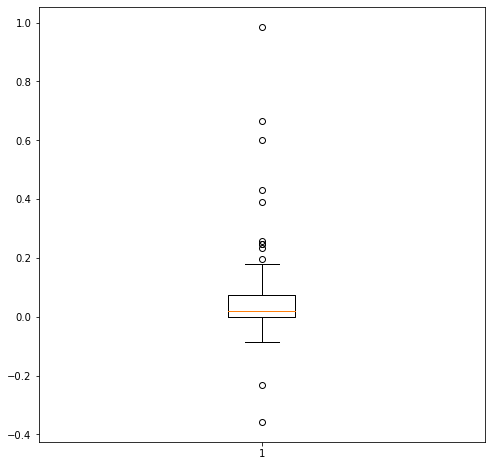

In [243]:
plt.figure(figsize=(8, 8))
plt.boxplot(differences);

### Caloric sufficiency

In [244]:
def get_prod(ssp):
    '''ssp: 2000 or ssp'''
    results_dir = data_path + 'outputs/compare/'
    if ssp == '2000':
        rez = pd.read_csv(os.path.join(results_dir, 'ssp1_compare_new.csv')) 
        return rez, rez['calories_2000'].sum()
    else:
        rez = pd.read_csv(os.path.join(results_dir, ssp + '_compare_new.csv'))
        rez = rez.set_index('pixel_id')
        return rez, rez['calories_2050'].sum()

In [245]:
def calc_CalSuff(prod_available, LS, pop,
            caloric_req = (2320*1e3*365.25) #in cal/capita/yr
           ):
    ''' prod_available (for Food not Feed + accounting for losses) - in Calories
        LS : animal calories availables
        pop : in capita
        caloric_req : default values is ADER=2320 kcal/cap/d (without fish)
        
        This is all per year
    '''
    return float((prod_available + LS) / (caloric_req * pop))

In [246]:
# Percetenge live stock in 2000
pctLS_2000 = .19
# Live stock value in 2000
LS_2000 = 1.1483e15*1e3 #calories
# Precentage of production used as food
pct_Prod_Food_2000 = .52

prod_2000, total_prod_2000 = get_prod('2000')
prod_by_country_2000 = prod_2000.groupby('name')['calories_2000'].sum()

#### Global level

In [247]:
# Old
# Quantity of food available in 2000 as food
prod_available_2000 = total_prod_2000*pct_Prod_Food_2000

# 2000 caloric sufficiency
global_CalSuff_2000_old = calc_CalSuff(prod_available_2000,
                       LS_2000,
                       total_old)

global_CalSuff_2000_old

1.956895410334835

In [248]:
# New
global_CalSuff_2000_new = calc_CalSuff(prod_available_2000,
                       LS_2000,
                       total_new)

global_CalSuff_2000_new

1.903637955540555

In [249]:
# Diff
float(global_CalSuff_2000_new - global_CalSuff_2000_old)/global_CalSuff_2000_old

-0.027215279116612315

#### Country level

In [250]:
# 2000 diet data FAOSTAT
diet_2000 = pd.read_csv(data_path + 'inputs/Diet/' + 'Consumption_2000_FAOSTAT.csv')

# LS 2000 Data with countries
LS_2000_df = diet_2000[diet_2000['Item']=='Animal Products'][['Country','Value']]
# kcal/capita/day to cal/capita
LS_2000_df['LS2000_percapita'] = LS_2000_df['Value'].apply(lambda x:x*1e3*365.25)


LS_2000_df = LS_2000_df[['Country','LS2000_percapita']].set_index('Country')

for c in unique_countries:
    pop_c = baseline_new.set_index('Location').at[c, 'PopTotal']
    try:
        LS_2000_df.loc[c, 'LS_2000_un'] = LS_2000_df.at[c,'LS2000_percapita'] * pop_c
        LS_2000_df.loc[c, 'LS_2000_jones'] = LS_2000_df.at[c,'LS2000_percapita'] * pop_bycountry_2000.loc[c]
    except:
        LS_2000_df.loc[c, 'LS_2000_un'] = LS_2000 / int(total_new) * pop_c
        LS_2000_df.loc[c, 'LS_2000_jones'] = LS_2000 / total_old * pop_bycountry_2000.loc[c]

In [253]:
def compute_country_calSuff(pop_country, scenario):
    if scenario == '2000':
        df = pd.concat([prod_by_country_2000.loc[unique_countries], pop_country.loc[unique_countries]], axis=1)
        df = df[df['calories_2000'] > 0]
        
        suff_country = df.apply(lambda r: calc_CalSuff(r['calories_2000']*pct_Prod_Food_2000, LS_2000_df.at[r.name, 'LS_2000_un'], r['PopTotal']), axis=1).replace([np.inf, -np.inf], np.nan)
        
        return suff_country
    else:
        return NotImplementedError

In [254]:
suff_old = sufficiency_old_df.loc[unique_countries]['2000']
suff_old

Afghanistan             0.785233
Angola                  0.597733
Albania                 2.319537
United Arab Emirates    0.403014
Argentina               8.343864
                          ...   
Vietnam                 1.306412
Yemen                   0.273570
South Africa            1.681635
Zambia                  2.483866
Zimbabwe                2.262618
Name: 2000, Length: 163, dtype: float64

In [255]:
suff_new = compute_country_calSuff(baseline_new.set_index('Location').loc[unique_countries], '2000')
suff_new

Afghanistan             0.752314
Angola                  0.558997
Albania                 2.243595
United Arab Emirates    0.393303
Argentina               8.304076
                          ...   
Vietnam                 1.259109
Yemen                   0.274540
South Africa            1.657406
Zambia                  2.510916
Zimbabwe                2.351255
Length: 163, dtype: float64

In [256]:
differences = pd.Series(index=unique_countries)

for c in unique_countries:
    old = suff_old.loc[c]
    new = suff_new.loc[c]
    diff = (new - old)
    differences.at[c] = diff

In [257]:
differences.sort_values(ascending=False).head(10)

Eritrea                   0.397555
Kyrgyzstan                0.390931
Bhutan                    0.174416
Georgia                   0.121530
Turkmenistan              0.110584
Zimbabwe                  0.088637
Swaziland                 0.063608
Kazakhstan                0.054556
Bosnia and Herzegovina    0.053829
Mali                      0.049459
dtype: float64

In [258]:
differences.describe()

count    163.000000
mean      -0.062056
std        0.165566
min       -0.944119
25%       -0.074892
50%       -0.018570
75%        0.000907
max        0.397555
dtype: float64

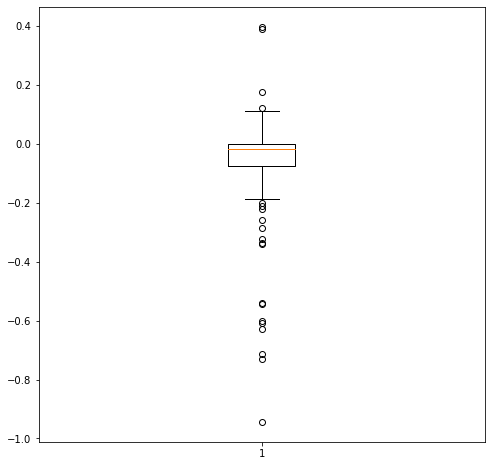

In [259]:
plt.figure(figsize=(8, 8))
plt.boxplot(differences);

In [652]:
ssps = ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5']

variants = ['Low', 'Medium', 'High', 'Constant fertility', 'Instant replacement', 'Momentum', 
            'Constant mortality', 'No change', 'Zero migration']

variant_mapping = ['ssp1 jones', 'ssp2 jones', 'ssp3 jones', 'ssp4 jones', 'ssp5 jones',
                   'ssp1 Low', 'ssp4 Low', 'ssp2 Medium', 'ssp3 High', 'ssp4 High', 
                   'ssp2 Constant fertility', 'ssp3 Constant fertility', 'ssp4 Constant fertility', 'ssp2 Instant replacement', 'ssp2 Momentum',
                   'ssp2 Constant mortality', 'ssp1 No change', 'ssp4 No change', 'ssp2 No change', 'ssp3 Zero migration', 
                   'ssp5 Constant fertility', 'ssp5 Instant replacement']

## Future

In [639]:
set(new_pop['Variant'])

{'Constant fertility',
 'Constant mortality',
 'High',
 'Instant replacement',
 'Low',
 'Lower 80 PI',
 'Lower 95 PI',
 'Median PI',
 'Medium',
 'Momentum',
 'No change',
 'Upper 80 PI',
 'Upper 95 PI',
 'Zero migration'}

### Population

In [262]:
for ssp in ssps:
    pop = import_old_pop_data(ssp)
    print(ssp, pop.sum()/1e9, 'e+09')

ssp1 7.949926714 e+09
ssp2 8.210591474 e+09
ssp3 9.929316985 e+09
ssp4 8.722972624 e+09
ssp5 8.248102437 e+09


In [263]:
for v in variants:
    baseline_new = new_pop[new_pop['Time'] == 2050]
    baseline_new = baseline_new[baseline_new['Variant'] == v]
    total_new = baseline_new.loc[baseline_new['Location'] == 'World', 'PopTotal']
    print(v, int(total_new)/1e9, 'e+09')

Low 8.906797099 e+09
Medium 9.7350339 e+09
High 10.587773913 e+09
Constant fertility 10.543229787 e+09
Instant replacement 9.4179804 e+09
Momentum 9.122680371 e+09
Constant mortality 9.33004994 e+09
No change 10.100631101 e+09
Zero migration 9.735283098 e+09


### Sufficiency

In [654]:
sufficiency_complete = pd.DataFrame(index=['World']+unique_countries, columns=['2000 jones', '2000 UN']+variant_mapping)

In [655]:
sufficiency_complete.loc[unique_countries, '2000 jones'] = suff_old
sufficiency_complete.loc[unique_countries, '2000 UN'] = suff_new

In [656]:
feed_conversion_factor = 2.3

# Data source: Bodirsky : share of calories in diet from animal products
pctLS_2050 = .19 #Assuming cst

In [658]:
def global_CalSuff_2050(pop,
                        ssp,
                        pctLS_2050 = .19):
    
    _, prod_2050 = get_prod(ssp)
    
    LS_2050 = pctLS_2050 * (prod_2050*pct_Prod_Food_2000 + feed_conversion_factor*LS_2000) / (1 + pctLS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000-LS_2050)
    
    prod_available = prod_2050*pct_Prod_Food_2000 + feed_now_food
    
    calsuff = calc_CalSuff(prod_available,
                           LS_2050,
                           pop)
    
    return float(calsuff)

In [659]:
def calc_CalSuff_numerator_2050(LS_2000_c,
                              pct_LS_2050,
                              prod):
    
    LS_2050 = pct_LS_2050 * (prod * pct_Prod_Food_2000 + feed_conversion_factor * LS_2000_c) / (1 + pct_LS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000_c - LS_2050)
    
    prod_available = prod * pct_Prod_Food_2000 + feed_now_food
        
    return (prod_available+LS_2050)

In [660]:
diets = pd.read_csv(data_path + 'inputs/Diet/' + 'pctLS_SSPs_Bodirsky.csv',sep=';')

In [661]:
caloric_req = 2320*1e3*365.25

In [662]:
prod_ssps = [get_prod(ssp) for ssp in ssps]

In [663]:
baseline_new = new_pop[new_pop['Time'] == 2000]

In [664]:
# Try load file, if it does not exist, recompute

try:
    sufficiency_complete = pd.read_csv(data_path + 'new_res/complete_suff.csv', index_col='Unnamed: 0')

except: 

    sufficiency_complete.at['World', '2000 jones'] = global_CalSuff_2000_old
    sufficiency_complete.at['World', '2000 UN'] = global_CalSuff_2000_new

    for v in variant_mapping:
        print(v)
        ssp, variant = v.split(' ', maxsplit=1)

        if variant == 'jones':
            pop = import_old_pop_data(ssp)
            total_pop = pop.sum()
        else: 
            # Get 2050 population only
            pop = new_pop[new_pop['Time'] == 2050]
            # Get total population
            pop = pop[pop['Variant'] == variant].set_index('Location')['PopTotal']
            total_pop = pop.at['World']
            

        # Compute global calsuff
        sufficiency_complete.at['World', v] = global_CalSuff_2050(total_pop, ssp)

        # Get production
        ssp_index = int(ssp[-1])-1
        prod, _ = prod_ssps[ssp_index]
        prod_bycountry = prod.groupby('name')['calories_2050'].sum()

        # Compute coutry calsuff
        for country in unique_countries:
            # Diet
            try:
                # Get from the data
                pct_LS_2050 = diets[(diets['Scenario'] == ssp) & (diets['Region'].apply(lambda i: iso_3_to_name.get(i)) == country)]['2050'].values[0]
            except IndexError:
                # Assume percentage constant as defined before if value not in data
                pct_LS_2050 = 0.19

            # Production
            prod_country = prod_bycountry.at[country]
            pop_country = pop.at[country]
            
            
            if variant == 'jones':
                pop_2000_country = pop_bycountry_2000.at[country]
                
                num = calc_CalSuff_numerator_2050(LS_2000_df.at[country, 'LS_2000_jones'],
                                              pct_LS_2050,
                                              prod=prod_country)
            else:
                pop_2000_country = int(baseline_new.loc[baseline_new['Location'] == country, 'PopTotal'])
                
                num = calc_CalSuff_numerator_2050(LS_2000_df.at[country, 'LS_2000_un'],
                                              pct_LS_2050,
                                              prod=prod_country)
            
           

            # sufficiency of the country
            sufficiency_complete.at[country, v] = num/(caloric_req*pop_country)

ssp1 jones
ssp2 jones
ssp3 jones
ssp4 jones
ssp5 jones
ssp1 Low
ssp4 Low
ssp2 Medium
ssp3 High
ssp4 High
ssp2 Constant fertility
ssp3 Constant fertility
ssp4 Constant fertility
ssp2 Instant replacement
ssp2 Momentum
ssp2 Constant mortality
ssp1 No change
ssp4 No change
ssp2 No change
ssp3 Zero migration
ssp5 Constant fertility
ssp5 Instant replacement


In [665]:
sufficiency_complete.head()

,2000 jones,2000 UN,ssp1 jones,ssp2 jones,ssp3 jones,ssp4 jones,ssp5 jones,ssp1 Low,ssp4 Low,ssp2 Medium,...,ssp4 Constant fertility,ssp2 Instant replacement,ssp2 Momentum,ssp2 Constant mortality,ssp1 No change,ssp4 No change,ssp2 No change,ssp3 Zero migration,ssp5 Constant fertility,ssp5 Instant replacement
World,1.9569,1.90364,1.42766,1.43698,1.19042,1.36136,1.48927,1.27428,1.33326,1.21196,...,1.12632,1.25276,1.29331,1.26457,1.12367,1.17568,1.16809,1.21415,1.16507,1.30427
Afghanistan,0.785233,0.752314,0.357539,0.30206,0.285515,0.265726,0.462921,0.324643,0.349199,0.31649,...,0.232838,0.367987,0.359137,0.331773,0.227318,0.244512,0.243755,0.322882,0.276097,0.43771
Angola,0.597733,0.558997,0.308747,0.397758,0.200725,0.310365,0.433238,0.184216,0.272841,0.219518,...,0.211433,0.347132,0.356321,0.231871,0.150981,0.223616,0.194772,0.157597,0.199694,0.376413
Albania,2.31954,2.2436,2.14432,2.11208,1.99776,2.15684,2.17247,2.73264,2.74893,2.46035,...,2.44531,2.16843,1.96723,2.57064,2.53729,2.55242,2.50235,2.03437,2.46303,2.22785
United Arab Emirates,0.403014,0.393303,0.158618,0.152754,0.143927,0.179645,0.109497,0.277701,0.311947,0.242482,...,0.277891,0.209756,0.221019,0.248963,0.253905,0.285217,0.245009,0.223483,0.213468,0.187571


In [666]:
sufficiency_complete.shape

(164, 24)

In [701]:
sufficiency_complete.to_csv(data_path + 'new_res/complete_suff.csv')

### Check results

In [857]:
sufficiency_complete = pd.read_csv(data_path + 'new_res/complete_suff.csv', index_col='Unnamed: 0')
sufficiency_complete.head()

,2000 jones,2000 UN,ssp1 jones,ssp2 jones,ssp3 jones,ssp4 jones,ssp5 jones,ssp1 Low,ssp4 Low,ssp2 Medium,ssp3 High,ssp4 High,ssp2 Constant fertility,ssp3 Constant fertility,ssp4 Constant fertility,ssp2 Instant replacement,ssp2 Momentum,ssp2 Constant mortality,ssp1 No change,ssp4 No change,ssp2 No change,ssp3 Zero migration,ssp5 Constant fertility,ssp5 Instant replacement
World,1.956895,1.903638,1.427659,1.436981,1.190419,1.361359,1.489266,1.274283,1.333262,1.211959,1.116387,1.121586,1.119056,1.121103,1.126324,1.252760,1.293311,1.264566,1.123671,1.175679,1.168092,1.214146,1.165072,1.304273
Afghanistan,0.785233,0.752314,0.357539,0.302060,0.285515,0.265726,0.462921,0.324643,0.349199,0.316490,0.308793,0.290453,0.232117,0.247540,0.232838,0.367987,0.359137,0.331773,0.227318,0.244512,0.243755,0.322882,0.276097,0.437710
Angola,0.597733,0.558997,0.308747,0.397758,0.200725,0.310365,0.433238,0.184216,0.272841,0.219518,0.146230,0.233741,0.184160,0.132274,0.211433,0.347132,0.356321,0.231871,0.150981,0.223616,0.194772,0.157597,0.199694,0.376413
Albania,2.319537,2.243595,2.144321,2.112085,1.997762,2.156844,2.172469,2.732636,2.748935,2.460350,2.135166,2.300137,2.397339,2.269928,2.445312,2.168429,1.967234,2.570645,2.537288,2.552421,2.502347,2.034367,2.463029,2.227846
United Arab Emirates,0.403014,0.393303,0.158618,0.152754,0.143927,0.179645,0.109497,0.277701,0.311947,0.242482,0.207846,0.257606,0.238716,0.224212,0.277891,0.209756,0.221019,0.248963,0.253905,0.285217,0.245009,0.223483,0.213468,0.187571


In [858]:
sufficiency_complete.loc['Vietnam']

2000 jones                  1.306412
2000 UN                     1.259109
ssp1 jones                  0.887877
ssp2 jones                  1.035278
ssp3 jones                  1.041431
ssp4 jones                  0.920984
ssp5 jones                  0.990350
ssp1 Low                    0.803300
ssp4 Low                    0.813238
ssp2 Medium                 0.802732
ssp3 High                   0.745026
ssp4 High                   0.687928
ssp2 Constant fertility     0.789068
ssp3 Constant fertility     0.794114
ssp4 Constant fertility     0.733254
ssp2 Instant replacement    0.779553
ssp2 Momentum               0.775926
ssp2 Constant mortality     0.827282
ssp1 No change              0.746195
ssp4 No change              0.755427
ssp2 No change              0.812929
ssp3 Zero migration         0.783211
ssp5 Constant fertility     0.788363
ssp5 Instant replacement    0.778855
Name: Vietnam, dtype: float64

In [859]:
# Global calsuff
sufficiency_complete.loc['World']

2000 jones                  1.956895
2000 UN                     1.903638
ssp1 jones                  1.427659
ssp2 jones                  1.436981
ssp3 jones                  1.190419
ssp4 jones                  1.361359
ssp5 jones                  1.489266
ssp1 Low                    1.274283
ssp4 Low                    1.333262
ssp2 Medium                 1.211959
ssp3 High                   1.116387
ssp4 High                   1.121586
ssp2 Constant fertility     1.119056
ssp3 Constant fertility     1.121103
ssp4 Constant fertility     1.126324
ssp2 Instant replacement    1.252760
ssp2 Momentum               1.293311
ssp2 Constant mortality     1.264566
ssp1 No change              1.123671
ssp4 No change              1.175679
ssp2 No change              1.168092
ssp3 Zero migration         1.214146
ssp5 Constant fertility     1.165072
ssp5 Instant replacement    1.304273
Name: World, dtype: float64

In [860]:
# Import old calsuff file
old_suff = pd.read_csv(data_path + '/related_datasets/sufficiencies_full.csv', index_col='name')
old_suff.head()

,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,GFSI,GDP,log_GDP,GNP,log_GNP,IncomeGroup,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp,Category
name,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,AFG,0.785233,0.357539,0.302060,0.285515,0.265726,0.462921,0,0.269311,NaN,520.896603,6.255552,550.0,6.309918,Low income,0.347358,0.750,0.334752,-0.450481,-0.519507,0.265726,0.462921,Most vulnerable
Angola,AGO,0.597733,0.308747,0.397758,0.200725,0.310365,0.433238,0,0.221301,0.386,3432.385736,8.141011,3370.0,8.122668,Lower middle income,0.989702,0.810,0.330167,-0.267566,-0.397008,0.200725,0.433238,Most vulnerable
Albania,ALB,2.319537,2.144321,2.112085,1.997762,2.156844,2.172469,0,0.208123,NaN,5253.630064,8.566675,4860.0,8.488794,Upper middle income,0.609977,0.937,2.116696,-0.202841,-0.321776,1.997762,2.172469,Decreasing but not as vulnerable
United Arab Emirates,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,0.725,43004.948646,10.669070,41010.0,10.621571,High income,0.001105,NaN,0.148888,-0.254126,-0.293517,0.109497,0.179645,Importers
Argentina,ARG,8.343864,5.579006,6.409942,6.254420,5.945893,6.103357,0,1.000000,0.692,11652.566290,9.363282,12370.0,9.423029,Upper middle income,0.804605,0.977,6.058524,-2.285340,-2.764858,5.579006,6.409942,Exporters


In [861]:
# Keep only the country we previously studied
sufficiency_countries = sufficiency_complete.loc[old_suff.index]
sufficiency_countries.head()

,2000 jones,2000 UN,ssp1 jones,ssp2 jones,ssp3 jones,ssp4 jones,ssp5 jones,ssp1 Low,ssp4 Low,ssp2 Medium,ssp3 High,ssp4 High,ssp2 Constant fertility,ssp3 Constant fertility,ssp4 Constant fertility,ssp2 Instant replacement,ssp2 Momentum,ssp2 Constant mortality,ssp1 No change,ssp4 No change,ssp2 No change,ssp3 Zero migration,ssp5 Constant fertility,ssp5 Instant replacement
name,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.785233,0.752314,0.357539,0.302060,0.285515,0.265726,0.462921,0.324643,0.349199,0.316490,0.308793,0.290453,0.232117,0.247540,0.232838,0.367987,0.359137,0.331773,0.227318,0.244512,0.243755,0.322882,0.276097,0.437710
Angola,0.597733,0.558997,0.308747,0.397758,0.200725,0.310365,0.433238,0.184216,0.272841,0.219518,0.146230,0.233741,0.184160,0.132274,0.211433,0.347132,0.356321,0.231871,0.150981,0.223616,0.194772,0.157597,0.199694,0.376413
Albania,2.319537,2.243595,2.144321,2.112085,1.997762,2.156844,2.172469,2.732636,2.748935,2.460350,2.135166,2.300137,2.397339,2.269928,2.445312,2.168429,1.967234,2.570645,2.537288,2.552421,2.502347,2.034367,2.463029,2.227846
United Arab Emirates,0.403014,0.393303,0.158618,0.152754,0.143927,0.179645,0.109497,0.277701,0.311947,0.242482,0.207846,0.257606,0.238716,0.224212,0.277891,0.209756,0.221019,0.248963,0.253905,0.285217,0.245009,0.223483,0.213468,0.187571
Argentina,8.343864,8.304076,5.579006,6.409942,6.254420,5.945893,6.103357,4.550943,4.863913,4.764825,4.268020,4.054018,4.569237,4.472211,4.247971,4.761514,4.901187,4.907301,4.089726,4.370977,4.701546,4.671633,4.347167,4.530099


### Inconsistent countries 2000

**Inconsistent countries are defined by a change of more than 15% of sufficiency in 2000 between the two population datasets.**

In [862]:
# Countries not consistent in 2000
sufficiency_countries[((sufficiency_countries['2000 jones'] < 1) &
                      (sufficiency_countries['2000 UN'] >= 1)) | 
                      ((sufficiency_countries['2000 jones'] >= 1) & 
                      (sufficiency_countries['2000 UN'] < 1))]

,2000 jones,2000 UN,ssp1 jones,ssp2 jones,ssp3 jones,ssp4 jones,ssp5 jones,ssp1 Low,ssp4 Low,ssp2 Medium,ssp3 High,ssp4 High,ssp2 Constant fertility,ssp3 Constant fertility,ssp4 Constant fertility,ssp2 Instant replacement,ssp2 Momentum,ssp2 Constant mortality,ssp1 No change,ssp4 No change,ssp2 No change,ssp3 Zero migration,ssp5 Constant fertility,ssp5 Instant replacement
name,,,,,,,,,,,,,,,,,,,,,,,,
Cyprus,1.429181,0.888164,0.971595,1.255055,1.263148,1.234032,0.818812,0.778089,0.779907,0.725593,0.685353,0.662532,0.729505,0.745707,0.720876,0.637699,0.753779,0.754883,0.748375,0.750124,0.759102,0.849611,0.838078,0.732609
Eritrea,0.951553,1.349109,0.557003,0.650152,0.576881,0.476653,0.555126,0.827178,0.849515,0.908962,0.729656,0.710897,0.764636,0.669001,0.651801,1.145804,1.095916,0.951962,0.664276,0.682214,0.800314,0.742589,0.634768,0.951198
Pakistan,1.021265,0.981726,0.560703,0.407565,0.460306,0.461578,0.633892,0.401955,0.491567,0.392595,0.400189,0.410524,0.336334,0.374133,0.383795,0.440353,0.433962,0.401764,0.321753,0.393485,0.344826,0.427777,0.334091,0.437417


In [863]:
inconsistant_countries = sufficiency_countries[abs(sufficiency_countries['2000 jones'] - sufficiency_countries['2000 UN'])/sufficiency_countries['2000 jones'] > 0.15]
inconsistant_countries

,2000 jones,2000 UN,ssp1 jones,ssp2 jones,ssp3 jones,ssp4 jones,ssp5 jones,ssp1 Low,ssp4 Low,ssp2 Medium,ssp3 High,ssp4 High,ssp2 Constant fertility,ssp3 Constant fertility,ssp4 Constant fertility,ssp2 Instant replacement,ssp2 Momentum,ssp2 Constant mortality,ssp1 No change,ssp4 No change,ssp2 No change,ssp3 Zero migration,ssp5 Constant fertility,ssp5 Instant replacement
name,,,,,,,,,,,,,,,,,,,,,,,,
Bhutan,0.823885,0.998302,0.691811,1.020644,1.044264,0.839683,0.599139,0.946222,1.236521,1.605290,1.729493,1.033240,1.510298,1.774974,1.060411,1.476937,1.502774,1.677474,0.846882,1.106703,1.576230,1.865646,0.743620,0.727194
Cyprus,1.429181,0.888164,0.971595,1.255055,1.263148,1.234032,0.818812,0.778089,0.779907,0.725593,0.685353,0.662532,0.729505,0.745707,0.720876,0.637699,0.753779,0.754883,0.748375,0.750124,0.759102,0.849611,0.838078,0.732609
Eritrea,0.951553,1.349109,0.557003,0.650152,0.576881,0.476653,0.555126,0.827178,0.849515,0.908962,0.729656,0.710897,0.764636,0.669001,0.651801,1.145804,1.095916,0.951962,0.664276,0.682214,0.800314,0.742589,0.634768,0.951198
Lebanon,0.898256,0.696685,0.813917,0.867939,0.988450,0.882850,0.824849,0.571689,0.618406,0.551327,0.574885,0.517334,0.530721,0.603372,0.542969,0.531759,0.412001,0.570175,0.518542,0.560915,0.548262,0.472986,0.511554,0.512554
Sierra Leone,1.454848,1.170234,0.958315,0.860458,0.749637,0.914912,1.220089,0.796680,0.806442,0.684606,0.527341,0.670114,0.540925,0.455810,0.579217,0.809685,0.830076,0.741606,0.621303,0.628916,0.587339,0.570191,0.729923,1.092586
Somalia,2.573276,1.629157,1.711494,1.119726,1.206096,1.093971,1.734126,0.425767,0.515872,0.486476,0.651705,0.443969,0.387379,0.558266,0.380315,0.765185,0.744187,0.515309,0.333395,0.403951,0.411454,0.673317,0.310474,0.613277


In [864]:
consistant_suff = sufficiency_countries.drop(inconsistant_countries.index, axis=0)

### Number of scenario analysis


In [865]:
jones_scenarios, un_scenarios = variant_mapping[:5], variant_mapping[5:]

#### Compute statistics

In [866]:
consistant_suff['avg_new_suff'] = consistant_suff[variant_mapping].mean(axis=1)
consistant_suff['avg_new_suff_jones'] = consistant_suff[jones_scenarios].mean(axis=1)
consistant_suff['avg_new_suff_un'] = consistant_suff[un_scenarios].mean(axis=1)

In [867]:
consistant_suff['avg_suff_2000'] = consistant_suff[['2000 jones', '2000 UN']].mean(axis=1)

In [868]:
consistant_suff['delta_avg'] = consistant_suff['avg_new_suff'] - consistant_suff['avg_suff_2000']
consistant_suff['delta_avg_jones'] = consistant_suff['avg_new_suff_jones'] - consistant_suff['2000 jones']
consistant_suff['delta_avg_un'] = consistant_suff['avg_new_suff_un'] - consistant_suff['2000 UN']

In [869]:
# Number of scenarios that goes up (or down) compared to max (or min) of 2000
consistant_suff['num_up'] = consistant_suff.apply(lambda r: len([v for v in variant_mapping if r[v] > max(r['2000 jones'], r['2000 UN'])]), axis=1)
consistant_suff['num_down'] = consistant_suff.apply(lambda r: len([v for v in variant_mapping if r[v] < min(r['2000 jones'], r['2000 UN'])]), axis=1)

consistant_suff['num_up_jones'] = consistant_suff.apply(lambda r: len([v for v in jones_scenarios if r[v] > r['2000 jones']]), axis=1)
consistant_suff['num_down_jones'] = consistant_suff.apply(lambda r: len([v for v in jones_scenarios if r[v] < r['2000 jones']]), axis=1)

consistant_suff['num_up_un'] = consistant_suff.apply(lambda r: len([v for v in un_scenarios if r[v] > r['2000 UN']]), axis=1)
consistant_suff['num_down_un'] = consistant_suff.apply(lambda r: len([v for v in un_scenarios if r[v] < r['2000 UN']]), axis=1)

In [870]:
# Maximum change
consistant_suff['delta_max'] = consistant_suff.apply(lambda r: min(r[variant_mapping]) - max(r['2000 jones'], r['2000 UN']) if abs(min(r[variant_mapping]) - max(r['2000 jones'], r['2000 UN'])) > abs(max(r[variant_mapping]) - min(r['2000 jones'], r['2000 UN'])) else max(r[variant_mapping]) - min(r['2000 jones'], r['2000 UN']), axis=1)
consistant_suff['delta_max_jones'] = consistant_suff.apply(lambda r: min(r[jones_scenarios]) - r['2000 jones'] if abs(min(r[jones_scenarios]) - r['2000 jones']) > abs(max(r[jones_scenarios]) - r['2000 jones']) else max(r[jones_scenarios]) - r['2000 jones'], axis=1)
consistant_suff['delta_max_un'] = consistant_suff.apply(lambda r: min(r[un_scenarios]) - r['2000 UN'] if abs(min(r[un_scenarios]) - r['2000 UN']) > abs(max(r[un_scenarios]) - r['2000 UN']) else max(r[un_scenarios]) - r['2000 UN'], axis=1)

In [871]:
consistant_suff['highest_future'] = consistant_suff[variant_mapping].max(axis=1)
consistant_suff['lowest_future'] = consistant_suff[variant_mapping].min(axis=1)

consistant_suff['highest_future_jones'] = consistant_suff[jones_scenarios].max(axis=1)
consistant_suff['lowest_future_jones'] = consistant_suff[jones_scenarios].min(axis=1)

consistant_suff['highest_future_un'] = consistant_suff[un_scenarios].max(axis=1)
consistant_suff['lowest_future_un'] = consistant_suff[un_scenarios].min(axis=1)

#### Analyze

Number of countries studied

In [872]:
len(consistant_suff)

154

Number of countries where cal suff decreases in all scenarios (across the 22 scenarios)

In [873]:
len(consistant_suff[consistant_suff['num_down'] == 22])

76

% of countries where cal suff decreases in all scenarios (across the 20 scenarios)

In [874]:
len(consistant_suff[consistant_suff['num_down'] == 22]) / len(consistant_suff)

0.4935064935064935

Number of countries where cal suff decreases in most scenarios (15 or more)

In [875]:
len(consistant_suff[consistant_suff['num_down'] >= 15])

108

Number of countries with calsuff < 1

In [876]:
consistant_suff.apply(lambda col: len([v for v in col if v < 1]))[['2000 jones', '2000 UN']+variant_mapping]

2000 jones                  47
2000 UN                     48
ssp1 jones                  65
ssp2 jones                  66
ssp3 jones                  71
ssp4 jones                  64
ssp5 jones                  63
ssp1 Low                    73
ssp4 Low                    65
ssp2 Medium                 73
ssp3 High                   73
ssp4 High                   77
ssp2 Constant fertility     82
ssp3 Constant fertility     71
ssp4 Constant fertility     80
ssp2 Instant replacement    75
ssp2 Momentum               70
ssp2 Constant mortality     70
ssp1 No change              83
ssp4 No change              77
ssp2 No change              76
ssp3 Zero migration         70
ssp5 Constant fertility     79
ssp5 Instant replacement    72
dtype: int64

### Categorization

In [877]:
# Add additional datasets
suff_added_data = consistant_suff.join(old_suff.drop(['ISO3', 'CalSuff_2000', 'delta_consistency', 'avg_new_suff', 'delta_CalSuff_avg', 'delta_max', 'lowest_ssp', 'highest_ssp', 'Category']+ssps, axis=1))

In [878]:
suff_added_data.columns

Index(['2000 jones', '2000 UN', 'ssp1 jones', 'ssp2 jones', 'ssp3 jones',
       'ssp4 jones', 'ssp5 jones', 'ssp1 Low', 'ssp4 Low', 'ssp2 Medium',
       'ssp3 High', 'ssp4 High', 'ssp2 Constant fertility',
       'ssp3 Constant fertility', 'ssp4 Constant fertility',
       'ssp2 Instant replacement', 'ssp2 Momentum', 'ssp2 Constant mortality',
       'ssp1 No change', 'ssp4 No change', 'ssp2 No change',
       'ssp3 Zero migration', 'ssp5 Constant fertility',
       'ssp5 Instant replacement', 'avg_new_suff', 'avg_new_suff_jones',
       'avg_new_suff_un', 'avg_suff_2000', 'delta_avg', 'delta_avg_jones',
       'delta_avg_un', 'num_up', 'num_down', 'num_up_jones', 'num_down_jones',
       'num_up_un', 'num_down_un', 'delta_max', 'delta_max_jones',
       'delta_max_un', 'highest_future', 'lowest_future',
       'highest_future_jones', 'lowest_future_jones', 'highest_future_un',
       'lowest_future_un', 'trade', 'GFSI', 'GDP', 'log_GDP', 'GNP', 'log_GNP',
       'IncomeGroup', 'wate

In [879]:
def custom_categorization_new(row, pop_file=None):
    # If population is from Jones
    if pop_file == 'Jones':
        if row['CalSuff_2000'] > 3 and row['trade'] > 0.8: 
            return 'Exporters' 
    
        elif (row['delta_CalSuff_avg'] > 0.6 and row['delta_consistency'] >= 3) or (row['CalSuff_2000'] > 1.2 and row['delta_consistency'] >= 3 and row['delta_CalSuff_avg'] > 0.2):
            return 'Increasing sufficiency'

        elif row['trade'] < 0.1:
            return 'Importers'

        elif row['CalSuff_2000'] < 1.2 and (row['delta_consistency'] <= 1 or row['highest_ssp'] < 0.9):
            return 'Most vulnerable'

        elif (row['lowest_ssp'] < 1 or row['CalSuff_2000'] < 2) and (row['delta_CalSuff_avg'] < -0.2 or row['lowest_ssp'] < 1) and row['delta_consistency'] <= 1:
            return 'Newly vulnerable'

        elif row['CalSuff_2000'] < 1.2 and row['delta_consistency'] >= 2 and row['lowest_ssp'] > 0.9*row['CalSuff_2000']:
            return 'Vulnerable but improving'

        elif row['delta_consistency'] <= 2 and row['delta_CalSuff_avg'] < -0.1 and row['CalSuff_2000'] > 2:
            return 'Decreasing but not as vulnerable'

        elif (row['delta_consistency'] > 0 and row['delta_consistency'] < 4) or (row['CalSuff_2000'] < row['highest_ssp'] and row['CalSuff_2000'] > row['lowest_ssp']):
            return 'Highly variable'  

        return 'Outliers'
    
    # IF population is from UN
    elif pop_file == 'UN':
        if row['2000 UN'] > 3 and row['trade'] > 0.8: 
            return 'Exporters' 

        elif (row['delta_avg_un'] > 0.6 and row['num_up_un'] >= 12) or (row['2000 UN'] > 1.2 and row['num_up_un'] >= 12 and row['delta_avg_un'] > 0.2):
            return 'Increasing sufficiency'

        elif row['trade'] < 0.1:
            return 'Importers'

        elif row['2000 UN'] < 1.2 and (row['num_down_un'] >= 12 or row['highest_future_un'] < 0.9):
            return 'Most vulnerable'

        elif (row['lowest_future_un'] < 1 or row['2000 UN'] < 2) and (row['delta_avg_un'] < -0.2 or row['lowest_future_un'] < 1) and row['num_down_un'] >= 12:
            return 'Newly vulnerable'

        elif row['2000 UN'] < 1.2 and row['num_up_un'] >= 7 and row['lowest_future_un'] > 0.9*row['2000 UN']:
            return 'Vulnerable but improving'

        elif row['num_down_un'] >= 7 and row['delta_avg_un'] < -0.1 and row['2000 UN'] > 2:
            return 'Decreasing but not as vulnerable'

        elif (row['num_down_un'] < 12 and row['num_up_un'] < 12) or (row['2000 UN'] < row['highest_future_un'] and row['2000 UN'] > row['lowest_future_un']):
            return 'Highly variable'  


        return 'Outliers'
    
    # If we study a combination of Jones and UN 
    else:
    
        if row['avg_suff_2000'] > 3 and row['trade'] > 0.8: 
            return 'Exporters' # e.g Brazil, USA, France, Denmark (Greenland)

        elif (row['delta_avg'] > 0.6 and row['num_up'] >= 15) or (row['avg_suff_2000'] > 1.2 and row['num_up'] >= 15 and row['delta_avg'] > 0.2):
            return 'Increasing sufficiency'

        elif row['trade'] < 0.1:
            return 'Importers'

        elif row['avg_suff_2000'] < 1.2 and (row['num_down'] >= 15 or row['highest_future'] < 0.9):
            return 'Most vulnerable'

        elif (row['lowest_future'] < 1 or row['avg_suff_2000'] < 2) and (row['delta_avg'] < -0.2 or row['lowest_future'] < 1) and row['num_down'] >= 15:
            return 'Newly vulnerable'

        elif row['avg_suff_2000'] < 1.2 and row['num_up'] >= 10 and row['lowest_future'] > 0.9*row['avg_suff_2000']:
            return 'Vulnerable but improving'

        elif row['num_down'] >= 10 and row['delta_avg'] < -0.1 and row['avg_suff_2000'] > 2:
            return 'Decreasing but not as vulnerable'

        elif (row['num_down'] < 15 and row['num_up'] < 15) or (row['num_down'] + row['num_up'] != 20):
            return 'Highly variable'  


        return 'Outliers'

In [880]:
# New categories
suff_added_data['UN category'] = suff_added_data.apply(lambda row: custom_categorization_new(row, pop_file='UN'), axis=1)

Compare with previous categories

In [881]:
cat_compare = pd.DataFrame(data=[old_suff['Category'].loc[suff_added_data.index], suff_added_data['UN category']]).T
cat_compare = cat_compare.rename(columns={'Category': 'Jones category'})
cat_compare.head()

,Jones category,UN category
name,,
Afghanistan,Most vulnerable,Most vulnerable
Angola,Most vulnerable,Most vulnerable
Albania,Decreasing but not as vulnerable,Highly variable
United Arab Emirates,Importers,Importers
Argentina,Exporters,Exporters


In [882]:
old_suff.loc[inconsistant_countries.index]['Category'].sort_values()

name
Somalia         Decreasing but not as vulnerable
Bhutan                           Highly variable
Cyprus                                 Importers
Lebanon                                Importers
Eritrea                          Most vulnerable
Sierra Leone                    Newly vulnerable
Name: Category, dtype: object

In [883]:
# Number of countries where category is different
cat_change = cat_compare[cat_compare['Jones category'] != cat_compare['UN category']]
len(cat_change)

32

In [884]:
cat_change.sort_values(by='Jones category').to_csv(new_res_path + 'cat_change_country.csv')

Sanity check when making changes in the categorization function that it does not change the old categories, dataframe should be empty.

In [885]:
test = old_suff.copy().loc[suff_added_data.index]
test['UN category'] = test.apply(lambda row: custom_categorization_new(row, pop_file='Jones'), axis=1)

test_compare = pd.DataFrame(data=[old_suff['Category'].loc[suff_added_data.index], test['UN category']]).T

test_compare[test_compare['Category'] != test_compare['UN category']]

,Category,UN category
name,,


In [886]:
suff_added_data['UN category'].value_counts()

Most vulnerable                     39
Newly vulnerable                    31
Importers                           20
Decreasing but not as vulnerable    18
Exporters                           16
Increasing sufficiency              15
Highly variable                     14
Vulnerable but improving             1
Name: UN category, dtype: int64

In [887]:
# Was in cat but not anymore
for cat in set(suff_added_data['UN category']):
    was_in = cat_compare[cat_compare['Jones category'] == cat]
    was_in_is_not = was_in[was_in['UN category'] != cat]
    print(cat, list(was_in_is_not.index), sep='\t')

Most vulnerable	[]
Exporters	[]
Vulnerable but improving	['Gabon', 'Equatorial Guinea', 'Morocco', 'Peru']
Increasing sufficiency	['Iran', 'Lesotho', 'Moldova', 'Mongolia', 'New Zealand', 'Swaziland', 'Tunisia']
Decreasing but not as vulnerable	['Albania', 'Bosnia and Herzegovina', 'Greece', 'Croatia', 'Italy', 'Macedonia', 'Mali', 'Papua New Guinea', 'Romania', 'Slovakia', 'Chad']
Highly variable	['Armenia', 'Switzerland', 'Ecuador', 'Cambodia', 'Myanmar', 'Namibia', 'Suriname', 'South Africa', 'Zimbabwe']
Newly vulnerable	['Ireland']
Importers	[]


In [888]:
# Was not in cat but is now
for cat in set(suff_added_data['UN category']):
    was_not = cat_compare[cat_compare['Jones category'] != cat]
    was_not_is_in = was_not[was_not['UN category'] == cat]
    print(cat, list(was_not_is_in.index), sep='\t')

Most vulnerable	['Ecuador', 'Equatorial Guinea', 'Morocco', 'Peru', 'Suriname']
Exporters	[]
Vulnerable but improving	['Lesotho']
Increasing sufficiency	['Armenia', 'Bosnia and Herzegovina', 'Greece', 'Namibia', 'Romania']
Decreasing but not as vulnerable	['Ireland', 'Mongolia']
Highly variable	['Albania', 'Gabon', 'Croatia', 'Iran', 'Italy', 'Moldova', 'Macedonia', 'New Zealand', 'Slovakia']
Newly vulnerable	['Switzerland', 'Cambodia', 'Mali', 'Myanmar', 'Papua New Guinea', 'Swaziland', 'Chad', 'South Africa', 'Zimbabwe']
Importers	['Tunisia']


In [889]:
# Mean CalSuff Jones 2000
old_suff.groupby('Category')['CalSuff_2000'].mean()

Category
Decreasing but not as vulnerable    3.100513
Exporters                           6.072764
Highly variable                     1.514558
Importers                           0.865300
Increasing sufficiency              2.194842
Most vulnerable                     0.771475
Newly vulnerable                    1.752894
Vulnerable but improving            0.570959
Name: CalSuff_2000, dtype: float64

In [890]:
# Mean CalSuff Jones 2050
old_suff.groupby('Category')[ssps].mean().mean(axis=1)

Category
Decreasing but not as vulnerable    2.218807
Exporters                           4.985210
Highly variable                     1.650424
Importers                           0.717401
Increasing sufficiency              3.497141
Most vulnerable                     0.470577
Newly vulnerable                    1.057040
Vulnerable but improving            0.969035
dtype: float64

In [891]:
# Mean CalSuff UN 2000
suff_added_data.groupby('UN category')['2000 UN'].mean()

UN category
Decreasing but not as vulnerable    3.132648
Exporters                           5.877755
Highly variable                     1.943769
Importers                           0.793798
Increasing sufficiency              2.317637
Most vulnerable                     0.735529
Newly vulnerable                    1.901664
Vulnerable but improving            0.765582
Name: 2000 UN, dtype: float64

In [893]:
# Mean CalSuff UN 2050
suff_added_data.groupby('UN category')[un_scenarios].mean().mean(axis=1)

UN category
Decreasing but not as vulnerable    2.098853
Exporters                           4.803328
Highly variable                     2.022979
Importers                           0.680110
Increasing sufficiency              3.315270
Most vulnerable                     0.420448
Newly vulnerable                    0.951693
Vulnerable but improving            1.104699
dtype: float64

In [894]:
suff_added_data.to_csv(new_res_path + 'suff_with_cat.csv')

# Country changes

In [895]:
suff_added_data = pd.read_csv(new_res_path + 'suff_with_cat.csv', index_col='name')

In [896]:
all_variants = ['2000 jones', '2000 UN'] + variant_mapping
all_variants

['2000 jones',
 '2000 UN',
 'ssp1 jones',
 'ssp2 jones',
 'ssp3 jones',
 'ssp4 jones',
 'ssp5 jones',
 'ssp1 Low',
 'ssp4 Low',
 'ssp2 Medium',
 'ssp3 High',
 'ssp4 High',
 'ssp2 Constant fertility',
 'ssp3 Constant fertility',
 'ssp4 Constant fertility',
 'ssp2 Instant replacement',
 'ssp2 Momentum',
 'ssp2 Constant mortality',
 'ssp1 No change',
 'ssp4 No change',
 'ssp2 No change',
 'ssp3 Zero migration',
 'ssp5 Constant fertility',
 'ssp5 Instant replacement']

In [741]:
prod_ssps = [get_prod(ssp) for ssp in ssps]

In [742]:
def get_changes(country):
    changes = pd.DataFrame(columns=all_variants, 
                           index=['Caloric Sufficiency', 'Production', 'Population', 'Cropland', 'Livestock'])
    
    changes = changes.rename_axis(country, axis=1)
    
    # sufficiency 2000
    changes.at['Caloric Sufficiency', '2000 jones'] = suff_added_data.loc[country, '2000 jones']
    changes.at['Caloric Sufficiency', '2000 UN'] = suff_added_data.loc[country, '2000 UN']
    # population 2000
    changes.at['Population', '2000 jones'] = pop_bycountry_2000[country]
    changes.at['Population', '2000 UN'] = baseline_new.loc[baseline_new['Location'] == country, 'PopTotal'].values[0]
    # production 2000
    changes.at['Production', '2000 jones'] = prod_by_country_2000[country]
    changes.at['Production', '2000 UN'] = prod_by_country_2000[country]
    # livestock 2000
    try:
        changes.at['Livestock', '2000 jones'] = diets[(diets['Scenario'] == 'ssp1') & (diets['Region'].apply(lambda i: iso_3_to_name.get(i)) == country)]['2000'].values[0]
    except:
        changes.at['Livestock', '2000 UN'] = np.nan
        pass
    changes.at['Livestock', '2000 UN'] = changes.at['Livestock', '2000 jones']
    
    
    df, _ = prod_ssps[0]
    # cropland 2000
    df['cropland_2000'] = df.dropna(subset=['calories_2000'])['ha_per_pixel'] * df.dropna(subset=['calories_2000'])['%cropland_2000']
    changes.at['Cropland', '2000 jones'] = df.groupby('name')['cropland_2000'].sum()[country]
    changes.at['Cropland', '2000 UN'] = df.groupby('name')['cropland_2000'].sum()[country]
    
    
    for variant in variant_mapping:
        ssp, pop_name = variant.split(' ', maxsplit=1)
        ssp_num = int(ssp[-1])
        df, _ = prod_ssps[ssp_num-1]
        # change in caloric sufficicency
        changes.at['Caloric Sufficiency', variant] = suff_added_data.loc[country, variant]
        
        # change in population
        if pop_name == 'jones':
            pop = import_old_pop_data(ssp)
            change_pop = (pop.at[country] - changes.at['Population', '2000 jones']) / changes.at['Population', '2000 jones']
            changes.at['Population', variant] = '{:+,.2f}%'.format(100*change_pop)
        else:
            # Get 2050 population only
            pop = new_pop[new_pop['Time'] == 2050]
            # Get total population
            pop = pop[pop['Variant'] == pop_name].set_index('Location')['PopTotal']
            change_pop = (pop.at[country] - changes.at['Population', '2000 UN']) / changes.at['Population', '2000 UN']
            changes.at['Population', variant] = '{:+,.2f}%'.format(100*change_pop)
            
        
        # change in production
        prod_bycountry = df.groupby('name')['calories_2050'].sum() 
        change_prod = (prod_bycountry[country] - changes.at['Production', '2000 jones']) / changes.at['Production', '2000 jones']
        changes.at['Production', variant] = '{:+,.2f}%'.format(100*change_prod)
        
        # change in cropland
        df['cropland_2050'] = df['ha_per_pixel'] * df['%cropland_2050']
        change_cropland = (df.groupby('name')['cropland_2050'].sum()[country] - changes.at['Cropland', '2000 jones']) / changes.at['Cropland', '2000 jones']
        changes.at['Cropland', variant] = '{:+,.2f}%'.format(100*change_cropland)
        
        # livestock
        try:
            changes.at['Livestock', variant] = diets[(diets['Scenario'] == ssp) & (diets['Region'].apply(lambda i: iso_3_to_name.get(i)) == country)]['2050'].values[0]
        except:
            changes.at['Livestock', variant] = np.nan
            pass
    # invert axis (transpose df)
    return changes.T 

In [316]:
# Creating Excel Writer Object from Pandas  
writer = pd.ExcelWriter(new_res_path + 'country_info_with_UN.xlsx', engine='xlsxwriter')   
workbook = writer.book
worksheet = workbook.add_worksheet('Country_results')
writer.sheets['Country_results'] = worksheet

country_list = suff_added_data.index.to_list()
start_row = 0
done = 0
for country in country_list:
    done += 1
    # compute information about the country
    changes = get_changes(country)
    # write to excel file
    changes.to_excel(writer, sheet_name='Country_results', startrow=start_row, startcol=0, index=True)
    start_row += len(changes) + 2
    print(f'{done}/{len(country_list)}')

# save excel file
writer.save()

1/154
2/154
3/154
4/154
5/154
6/154
7/154
8/154
9/154
10/154
11/154
12/154
13/154
14/154
15/154
16/154
17/154
18/154
19/154
20/154
21/154
22/154
23/154
24/154
25/154
26/154
27/154
28/154
29/154
30/154
31/154
32/154
33/154
34/154
35/154
36/154
37/154
38/154
39/154
40/154
41/154
42/154
43/154
44/154
45/154
46/154
47/154
48/154
49/154
50/154
51/154
52/154
53/154
54/154
55/154
56/154
57/154
58/154
59/154
60/154
61/154
62/154
63/154
64/154
65/154
66/154
67/154
68/154
69/154
70/154
71/154
72/154
73/154
74/154
75/154
76/154
77/154
78/154
79/154
80/154
81/154
82/154
83/154
84/154
85/154
86/154
87/154
88/154
89/154
90/154
91/154
92/154
93/154
94/154
95/154
96/154
97/154
98/154
99/154
100/154
101/154
102/154
103/154
104/154
105/154
106/154
107/154
108/154
109/154
110/154
111/154
112/154
113/154
114/154
115/154
116/154
117/154
118/154
119/154
120/154
121/154
122/154
123/154
124/154
125/154
126/154
127/154
128/154
129/154
130/154
131/154
132/154
133/154
134/154
135/154
136/154
137/154
138/154
139/

In [317]:
changes

,Caloric Sufficiency,Production,Population,Cropland,Livestock
Zimbabwe,,,,,
2000 jones,2.26262,4.41058e+16,1.23625e+07,1.22162e+07,0.0838
2000 UN,2.35126,4.41058e+16,1.18815e+07,1.22162e+07,0.0838
ssp1 jones,1.76758,-0.28%,+11.61%,+11.58%,0.1477
ssp2 jones,2.20725,+24.64%,+12.26%,+40.21%,0.1302
ssp3 jones,3.02941,+74.01%,+13.07%,+75.03%,0.1242
ssp4 jones,2.2473,+24.18%,+12.45%,+33.23%,0.1096
ssp5 jones,2.69887,+55.28%,+10.70%,+58.39%,0.1494
ssp1 Low,1.12368,-0.28%,+82.17%,+11.58%,0.1477
ssp4 Low,1.44016,+24.18%,+82.17%,+33.23%,0.1096


# Sensitivity Analysis on population

In [897]:
suff_added_data = pd.read_csv(new_res_path + 'suff_with_cat.csv', index_col='name')
un_pop = pd.read_csv(new_pop_data_path + 'WPP2019_TotalPopulationBySex.csv')[['Location', 
                                                                               'Time', 
                                                                               'Variant', 
                                                                               'PopTotal']]
un_pop['PopTotal'] = un_pop['PopTotal'] * 1000
un_pop = un_pop.replace(country_name_mapping)

In [901]:
cat_compare = pd.DataFrame(data=[old_suff['Category'].loc[suff_added_data.index], suff_added_data['UN category']]).T
cat_compare = cat_compare.rename(columns={'Category': 'Jones category'})

# Number of countries where category is different
cat_change = cat_compare[cat_compare['Jones category'] != cat_compare['UN category']]
same_cat_countries = suff_added_data.loc[cat_compare[cat_compare['Jones category'] == cat_compare['UN category']].index]

In [902]:
cat_order = ['Most vulnerable', 'Newly vulnerable', 
             'Exporters', 'Importers', 
             'Decreasing but not as vulnerable', 'Increasing sufficiency']
color_map = ['#610002', '#BE0003',
             '#3B6EE2', '#7B65B6',
             '#EDAE12', '#296517']




In [903]:
ssps = ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5']

variants = ['jones', 'Low', 'Medium', 'High', 'Constant fertility', 'Instant replacement', 'Momentum', 
            'Constant mortality', 'No change', 'Zero migration']

variant_mapping = ['ssp1 jones', 'ssp2 jones', 'ssp3 jones', 'ssp4 jones', 'ssp5 jones',
                   'ssp1 Low', 'ssp4 Low', 'ssp2 Medium', 'ssp3 High', 'ssp4 High', 
                   'ssp2 Constant fertility', 'ssp3 Constant fertility', 'ssp4 Constant fertility', 'ssp2 Instant replacement', 'ssp2 Momentum',
                   'ssp2 Constant mortality', 'ssp1 No change', 'ssp4 No change', 'ssp2 No change', 'ssp3 Zero migration', 
                   'ssp5 Constant fertility', 'ssp5 Instant replacement']

linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid']

## Representative country

In [748]:
# Get the population for each ssp/variant pair sorted by ascending order

pops = {}
for ssp in ssps:
    for variant in variants:
        ssp_variant = (' ').join([ssp, variant])
        if ssp_variant in variant_mapping:
            # Population
            if variant == 'jones':
                pop = import_old_pop_data(ssp)
                pop = pop.sum()
            else:
                pop = un_pop.loc[(un_pop['Location'] == 'World') & (un_pop['Time'] == 2050)& (un_pop['Variant'] == variant), 'PopTotal']
                pop = int(pop)
            pops[ssp_variant] = pop

ordered_vars = list({k: v for k, v in sorted(pops.items(), key=lambda item: item[1])}.keys())

In [749]:
def custom_categorization_unique_country(suff_2000, suff_future, trade):
    delta_suff = suff_future - suff_2000
    

    if suff_2000 > 3 and trade > 0.8: 
        return 'Exporters' # e.g Brazil, USA, France, Denmark (Greenland)

    elif delta_suff > 0.6 or (suff_2000 > 1.2 and delta_suff > 0.2):
        return 'Increasing sufficiency'

    elif trade < 0.1:
        return 'Importers'

    elif suff_2000 < 1.2 and suff_future < 0.9:
        return 'Most vulnerable'

    elif (suff_future < 1 or suff_2000 < 2) and (delta_suff < -0.2 or suff_future < 1):
        return 'Newly vulnerable'

    elif suff_2000 < 1.2 and 2 and suff_future > 0.9*suff_2000:
        return 'Vulnerable but improving'

    elif delta_suff < -0.1 and suff_2000 > 2:
        return 'Decreasing but not as vulnerable'

    # no more Highly variable
    """elif (suff_2000 < row['highest_ssp'] and suff_2000 > row['lowest_ssp']):
        return 'Highly variable'  
"""
    return 'Outliers'


In [750]:
# Check if categorization is consistent

country_cats = dict()

for c in same_cat_countries.index:
    for c, row in same_cat_countries.iterrows():
        # The category we found using the UN populations
        cat = [row['UN category']]
        country_cats[c] = cat
        trade = row['trade']
        for v in variant_mapping:
            if 'jones' in v:
                new_cat = custom_categorization_unique_country(row['2000 jones'], row[v], trade)
            else: 
                new_cat = custom_categorization_unique_country(row['2000 UN'], row[v], trade)
            cats = country_cats[c]
            cats.append(new_cat)
            country_cats[c] = cats

In [751]:
# How many countries have a robust categorization (same with all scenario) 

i=0
for k,v in country_cats.items():
    unique = set(v)

    if len(list(unique)) == 1:
        i += 1
i

93

In [752]:
# Which countries are robust

for k,v in country_cats.items():
    unique = set(v)

    if len(list(unique)) == 1:
        print(k, unique)

Afghanistan {'Most vulnerable'}
Angola {'Most vulnerable'}
United Arab Emirates {'Importers'}
Argentina {'Exporters'}
Australia {'Exporters'}
Austria {'Decreasing but not as vulnerable'}
Azerbaijan {'Decreasing but not as vulnerable'}
Burundi {'Most vulnerable'}
Belgium {'Importers'}
Benin {'Newly vulnerable'}
Bangladesh {'Most vulnerable'}
Bulgaria {'Exporters'}
Belize {'Exporters'}
Bolivia {'Newly vulnerable'}
Brazil {'Exporters'}
Brunei {'Importers'}
Canada {'Exporters'}
Chile {'Decreasing but not as vulnerable'}
China {'Newly vulnerable'}
Cameroon {'Most vulnerable'}
Democratic Republic of the Congo {'Most vulnerable'}
Costa Rica {'Newly vulnerable'}
Czech Republic {'Decreasing but not as vulnerable'}
Germany {'Decreasing but not as vulnerable'}
Djibouti {'Importers'}
Denmark {'Exporters'}
Dominican Republic {'Most vulnerable'}
Algeria {'Importers'}
Egypt {'Most vulnerable'}
Estonia {'Increasing sufficiency'}
Ethiopia {'Most vulnerable'}
Finland {'Increasing sufficiency'}
France {'

In [756]:
# Global cal suff by ssp

global_val = dict()
for ssp in ssps:
    global_val[ssp] = []

for ssp_variant in variant_mapping:
    ssp, variant = ssp_variant.split(' ', maxsplit=1)
    if variant == 'jones':
        pop = import_old_pop_data(ssp)
        pop = pop.sum()
    else:
        pop = un_pop.loc[(un_pop['Location'] == 'World') & (un_pop['Time'] == 2050)& (un_pop['Variant'] == variant), 'PopTotal']
        pop = int(pop)
    
    suff = sufficiency_complete.at['World', ssp_variant]
    global_val[ssp].append([pop, suff])

for ssp in ssps:
    global_val[ssp] = sorted(global_val[ssp], key=lambda x: x[0])
    

In [753]:
cat_order

['Most vulnerable',
 'Newly vulnerable',
 'Exporters',
 'Importers',
 'Decreasing but not as vulnerable',
 'Increasing sufficiency']

In [797]:
# The number of ssp for each country where cal suff decreases with population increasing 

count_c = []
for ssp in ssps:
    ordered_ssp = [x for x in ordered_vars if ssp in x]
    ordered_suff = suff_added_data[ordered_ssp]
    for c, r in ordered_suff.iterrows():
        l = r.values
        if all(l[i] >= l[i+1] for i in range(len(l)-1)):
            count_c.append(c)
            
count_c = [[x, count_c.count(x)] for x in set(count_c)]
#count_c

In [904]:
# The countries we study
repres_c_order = ['Cameroon', 'Mexico', 'Canada', 'Algeria', 'Germany', 'Poland']

In [905]:
# Check average suff of countries to see if representative of the category

suff_added_data.loc[repres_c_order][ordered_vars].mean(axis=1)

name
Cameroon    0.437632
Mexico      0.996096
Canada      5.574854
Algeria     0.539919
Germany     2.318769
Poland      3.722842
dtype: float64

In [906]:
# Country values by ssp

values = dict()

for c in repres_c_order:
    c_data = same_cat_countries.loc[c]
    ssp_dict = dict()
    for ssp in ssps:
        pops, suffs = [], []
        for variant in variants:
            ssp_variant = (' ').join([ssp, variant])
            if ssp_variant in variant_mapping:
                # Population
                if variant == 'jones':
                    pop = import_old_pop_data(ssp)
                    pop = pop.sum()
                else:
                    pop = un_pop.loc[(un_pop['Location'] == 'World') & (un_pop['Time'] == 2050)& (un_pop['Variant'] == variant), 'PopTotal']
                    pop = int(pop)
                
                # Sufficiency
                variant_data = c_data[ssp_variant]
                
                pops.append(pop)
                suffs.append(variant_data)
        ssp_dict[ssp] = [sorted(pops), [suff for _, suff in sorted(zip(pops, suffs))]]
    values[c] = ssp_dict

In [916]:
studied_countries_df = suff_added_data.loc[repres_c_order][ordered_vars]
studied_countries_df.loc['World'] = sufficiency_complete.loc['World'][ordered_vars]
studied_countries_df

,ssp1 jones,ssp2 jones,ssp5 jones,ssp4 jones,ssp1 Low,ssp4 Low,ssp2 Momentum,ssp2 Constant mortality,ssp2 Instant replacement,ssp5 Instant replacement,ssp2 Medium,ssp3 Zero migration,ssp3 jones,ssp1 No change,ssp2 No change,ssp4 No change,ssp2 Constant fertility,ssp3 Constant fertility,ssp4 Constant fertility,ssp5 Constant fertility,ssp3 High,ssp4 High
name,,,,,,,,,,,,,,,,,,,,,,
Cameroon,0.436841,0.490864,0.762979,0.511140,0.355661,0.437748,0.527774,0.407162,0.515597,0.761470,0.384263,0.373185,0.471247,0.294810,0.346783,0.362853,0.326913,0.318826,0.342063,0.482808,0.345852,0.371059
Mexico,1.237626,1.268722,1.273100,1.371208,1.021943,1.134151,0.916893,0.979206,0.903763,0.908756,0.949336,0.956678,0.694689,0.896915,0.920158,0.995395,0.893241,0.911437,0.966278,0.898176,0.881692,0.934743
Canada,4.629821,6.664350,3.547303,7.910551,5.352916,5.951042,6.586719,5.728743,5.034637,4.411701,5.539252,6.520904,7.424824,5.097303,5.720505,5.666867,5.531537,5.142160,5.479671,4.847120,4.772797,5.086064
Algeria,0.987536,0.841282,0.727111,0.784222,0.623266,0.495509,0.529223,0.504027,0.520769,0.448247,0.490481,0.498407,0.487294,0.524052,0.448906,0.416632,0.437413,0.447518,0.405966,0.376500,0.463444,0.420414
Germany,2.237717,2.377024,2.112093,2.315383,2.416924,2.500936,2.507539,2.492311,2.219374,1.973739,2.378263,2.439490,2.257163,2.374545,2.522594,2.457083,2.405912,2.284530,2.343432,2.139632,2.101524,2.155707
Poland,3.224346,3.311737,3.226428,3.312734,4.043729,4.155634,3.621744,4.045444,3.489906,3.399760,3.832637,3.822741,3.340694,4.033100,4.143468,4.144711,3.920772,3.955097,3.921949,3.819497,3.583210,3.553178
World,1.427659,1.436981,1.489266,1.361359,1.274283,1.333262,1.293311,1.264566,1.252760,1.304273,1.211959,1.214146,1.190419,1.123671,1.168092,1.175679,1.119056,1.121103,1.126324,1.165072,1.116387,1.121586


In [917]:
studied_countries_df.to_csv(new_res_path + 'studied_countries.csv')

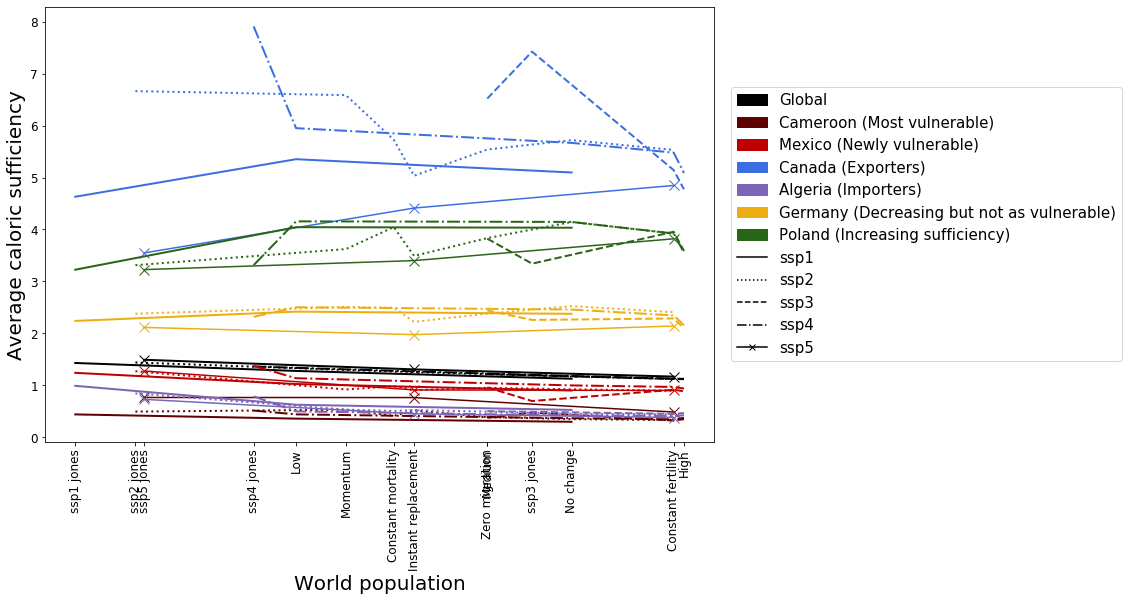

In [909]:
fig, ax = plt.subplots(figsize=(12, 8))

# Global


for i,ssp in enumerate(ssps):
    to_plot = np.array(global_val[ssp])
    if i==4:
        plt.plot([x/1e9 for x in to_plot[:, 0]], to_plot[:, 1], c='k', linestyle=linestyles[i], marker='x', markersize=10, linewidth=2) 
    else:
        plt.plot([x/1e9 for x in to_plot[:, 0]], to_plot[:, 1], c='k', linestyle=linestyles[i], linewidth=2)
        
    
for i, c in enumerate(repres_c_order):
    color = color_map[i]
    for j, ssp in enumerate(ssps):
        linestyle = linestyles[j]
        to_plot = values[c][ssp]
        if j==4:
            plt.plot([x/1e9 for x in to_plot[0]], to_plot[1], c=color, linestyle=linestyle, marker='x', markersize=10)
        else:
            plt.plot([x/1e9 for x in to_plot[0]], to_plot[1], c=color, linestyle=linestyle, linewidth=2)

            
patches = []
patches.append(mpatches.Patch(color='k', label='Global'))
for i, cat in enumerate(cat_order):
     patches.append(mpatches.Patch(color=color_map[i], label=f'{repres_c_order[i]} ({cat})'))
for i, ssp in enumerate(ssps):
    if i==4:
        patches.append(Line2D([], [], color='k', marker='x', linestyle='solid', label=ssp))
    else:
        patches.append(Line2D([0,1],[0,1],linestyle=linestyles[i], color='k', label=ssp))
    
    
plt.xlabel('World population', fontsize=20)
plt.ylabel('Average caloric sufficiency', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.xticks([x/1e9 for x in list(OrderedDict.fromkeys(global_suffs[0]))], rotation='vertical')

unique_order_v = [v if 'jones' in v else v.split(' ', maxsplit=1)[1] for v in ordered_vars]
unique_order_v = list(OrderedDict.fromkeys(unique_order_v))

ax.set_xticklabels(unique_order_v)

lgd = plt.legend(handles=patches, bbox_to_anchor=(1.62,0.5), loc='center right', fontsize=15)
#plt.savefig(new_res_path + 'SA_pop_avg_with_legend.png', dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [768]:
list(zip(list(OrderedDict.fromkeys(global_suffs[0])), unique_order_v))

[(7949926714, 'ssp1 jones'),
 (8210591474, 'ssp2 jones'),
 (8248102437, 'ssp5 jones'),
 (8722972624, 'ssp4 jones'),
 (8906797099, 'Low'),
 (9122680371, 'Momentum'),
 (9330049940, 'Constant mortality'),
 (9417980400, 'Instant replacement'),
 (9735033900, 'Medium'),
 (9735283098, 'Zero migration'),
 (9929316985, 'ssp3 jones'),
 (10100631101, 'No change'),
 (10543229787, 'Constant fertility'),
 (10587773913, 'High')]

## Barplots

In [770]:
ordered_vars

['ssp1 jones',
 'ssp2 jones',
 'ssp5 jones',
 'ssp4 jones',
 'ssp1 Low',
 'ssp4 Low',
 'ssp2 Momentum',
 'ssp2 Constant mortality',
 'ssp2 Instant replacement',
 'ssp5 Instant replacement',
 'ssp2 Medium',
 'ssp3 Zero migration',
 'ssp3 jones',
 'ssp1 No change',
 'ssp2 No change',
 'ssp4 No change',
 'ssp2 Constant fertility',
 'ssp3 Constant fertility',
 'ssp4 Constant fertility',
 'ssp5 Constant fertility',
 'ssp3 High',
 'ssp4 High']

In [771]:
# Compute unique country category for each scenario

box_values = []
for v in ordered_vars:
    v_values = []
    sub_data = suff_added_data[v]
    for c in sub_data.index:
        if 'jones' in v:
            cat = custom_categorization_unique_country(suff_added_data.at[c, '2000 jones'], 
                                                       sub_data.loc[c], 
                                                       suff_added_data.at[c, 'trade'])
        else: 
            cat = custom_categorization_unique_country(suff_added_data.at[c, '2000 UN'], 
                                                       sub_data.loc[c], 
                                                       suff_added_data.at[c, 'trade'])
        v_values.append(cat)
    box_values.append(v_values)

In [910]:
val_count = pd.DataFrame(box_values, index=ordered_vars, columns=suff_added_data.index).T

In [911]:
pd.set_option('display.max_columns', None)
val_count_df = val_count.apply(lambda c: c.value_counts()).loc[cat_order, ordered_vars]
val_count_df

,ssp1 jones,ssp2 jones,ssp5 jones,ssp4 jones,ssp1 Low,ssp4 Low,ssp2 Momentum,ssp2 Constant mortality,ssp2 Instant replacement,ssp5 Instant replacement,ssp2 Medium,ssp3 Zero migration,ssp3 jones,ssp1 No change,ssp2 No change,ssp4 No change,ssp2 Constant fertility,ssp3 Constant fertility,ssp4 Constant fertility,ssp5 Constant fertility,ssp3 High,ssp4 High
Most vulnerable,38,42,36,36,40,37,39,41,41,40,42,40,39.0,42,42,40.0,42.0,41,42.0,41,41,39.0
Newly vulnerable,24,18,18,24,29,26,27,27,28,23,27,24,24.0,34,30,31.0,34.0,25,30.0,30,25,32.0
Exporters,16,16,16,16,16,16,16,16,16,16,16,16,16.0,16,16,16.0,16.0,16,16.0,16,16,16.0
Importers,19,19,20,19,19,19,21,21,21,21,21,19,20.0,20,21,20.0,21.0,20,20.0,21,20,20.0
Decreasing but not as vulnerable,31,29,31,27,18,22,30,22,30,30,23,25,31.0,17,19,19.0,19.0,24,20.0,23,30,27.0
Increasing sufficiency,18,18,24,18,19,21,13,17,12,14,14,20,18.0,16,16,19.0,12.0,18,17.0,15,15,13.0


In [ ]:
val_count_df.to_csv(new_res_path + 'value_counts_cat.csv')

# Interpretation

In [778]:
global_val

{'ssp1': [[7949926714, 1.427658915626177],
  [8906797099, 1.274283406892821],
  [10100631101, 1.1236707526813001]],
 'ssp2': [[8210591474, 1.4369811505366614],
  [9122680371, 1.293311253170839],
  [9330049940, 1.264566134025969],
  [9417980400, 1.252759581331792],
  [9735033900, 1.2119593320466018],
  [10100631101, 1.1680918810832457],
  [10543229787, 1.119056059789454]],
 'ssp3': [[9735283098, 1.2141456016581238],
  [9929316985, 1.1904193583697311],
  [10543229787, 1.1211034372889908],
  [10587773913, 1.116386810895533]],
 'ssp4': [[8722972624, 1.3613588557929253],
  [8906797099, 1.3332622151968536],
  [10100631101, 1.1756786196603075],
  [10543229787, 1.1263243114708423],
  [10587773913, 1.121585720188023]],
 'ssp5': [[8248102437, 1.4892657603044688],
  [9417980400, 1.3042728934653494],
  [10543229787, 1.1650715003910737]]}